In [94]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as skpreprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from pylab import rcParams

In [95]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysis.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysistest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
#df = df.drop(df[df.diskioWritten > 500000].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,7.452470,0.000129,0.000000,1.484572e+04,0.006211,7.686411e+02,690.618472,1.0,7.0,0.427801,12.0,76.330988,5.045532e+10,10.168922
1,6.314931,0.056578,903.680000,7.635895e+06,0.006211,4.423151e+06,44196.825694,1.0,42.0,0.441701,12.0,76.330988,5.045532e+10,10.168922
2,9.499113,0.073244,1001.244444,9.543407e+06,0.006211,4.011359e+06,41064.000000,1.0,76.0,0.429230,12.0,13.216667,5.045532e+10,10.329697
3,6.085528,0.073156,1001.244444,9.533212e+06,0.026095,4.012145e+06,42053.311111,1.0,112.0,0.421655,12.0,13.216667,5.045532e+10,10.329697
4,9.452724,0.021956,182.044444,2.628813e+06,0.119376,3.909378e+03,3469.288889,1.0,140.0,0.439443,12.0,14.213889,5.045532e+10,10.159327


In [96]:
# remove 2xlarge
#df = df.drop(df[df.totalcpu > 16].index)

In [97]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [98]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,6.137011,513.076211,0.427801,7.0
1,6.137011,513.076211,0.441701,42.0
2,1.062620,521.188136,0.429230,76.0
3,1.062620,521.188136,0.421655,112.0
4,1.142797,512.592066,0.439443,140.0


In [99]:
df.totalmemory = df.totalmemory*1e-9
df.networkTransmitted = (df.networkTransmitted+df.networkReceived)/10000
df = df.drop(df[df.networkTransmitted > 100].index)

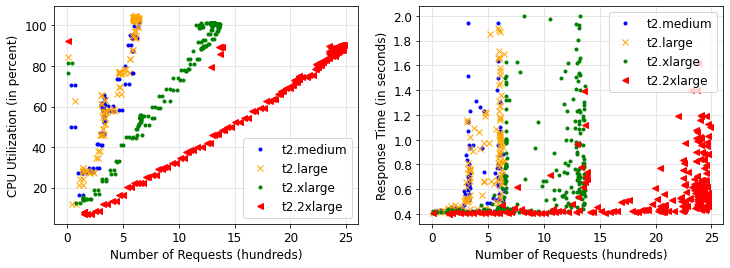

In [101]:
rcParams['figure.figsize'] = 12, 4
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
fig, (ax1, ax2) = plt.subplots(1, 2)
#ax1 = plt.subplot(111)


ax1.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax1.set_xlabel("Number of Requests (hundreds)")
ax1.set_ylabel("CPU Utilization (in percent)")
ax1.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['totalcpuUtilization'],'.', label = "t2.medium", color="blue")
ax1.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['totalcpuUtilization'], 'x', label = "t2.large", color="orange")
ax1.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['totalcpuUtilization'], '.',label = "t2.xlarge", color="green")
ax1.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['totalcpuUtilization'], '<', label = "t2.2xlarge", color="red")


#ax2.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
#ax2.set_xlabel("Number of Requests (thousands)")
#ax2.set_ylabel("Mem Utilization (in percent)")
#ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['totalmemoryUtilization'],'.', label = "t2.medium", color="blue")
#ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['totalmemoryUtilization'], 'x', label = "t2.large", color="orange")
#ax2.plot(df[df.totalcpu == 12]['requests']/1000, df[df.totalcpu == 12]['totalmemoryUtilization'], '.',label = "t2.xlarge", color="green")
#ax2.plot(df[df.totalcpu > 12]['requests']/1000, df[df.totalcpu > 12]['totalmemoryUtilization'], '<', label = "t2.2xlarge", color="red")

#ax3.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
#ax3.set_xlabel("Number of Requests (thousands)")
#ax3.set_ylabel("Disk I/O Utilization (in percent)")
#ax3.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['diskio'],'.', label = "t2.medium", color="blue")
#ax3.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['diskio'], 'x', label = "t2.large", color="orange")
#ax3.plot(df[df.totalcpu == 12]['requests']/1000, df[df.totalcpu == 12]['diskio'], '.',label = "t2.xlarge", color="green")
#ax3.plot(df[df.totalcpu > 12]['requests']/1000, df[df.totalcpu > 12]['diskio'], '<', label = "t2.2xlarge", color="red")

#ax4.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
#ax4.set_xlabel("Number of Requests (hundreds)")
#ax4.set_ylabel("NetworkIO Utilization (in percent)")
#ax4.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['networkTransmitted'],'.', label = "t2.medium", color="blue")
#ax4.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['networkTransmitted'], 'x', label = "t2.large", color="orange")
#ax4.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['networkTransmitted'], '.',label = "t2.xlarge", color="green")
#ax4.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['networkTransmitted'], '<', label = "t2.2xlarge", color="red")

ax2.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax2.set_xlabel("Number of Requests (hundreds)")
ax2.set_ylabel("Response Time (in seconds)")
ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['responsetime'],'.', label = "t2.medium", color="blue")
ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['responsetime'], 'x', label = "t2.large", color="orange")
ax2.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['responsetime'], '.',label = "t2.xlarge", color="green")
ax2.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['responsetime'], '<', label = "t2.2xlarge", color="red")


ax1.legend()
ax2.legend()
plt.show()
fig.savefig('resultSentimentAnalysis.pdf',bbox_inches = 'tight',pad_inches = 0,  dpi=300)

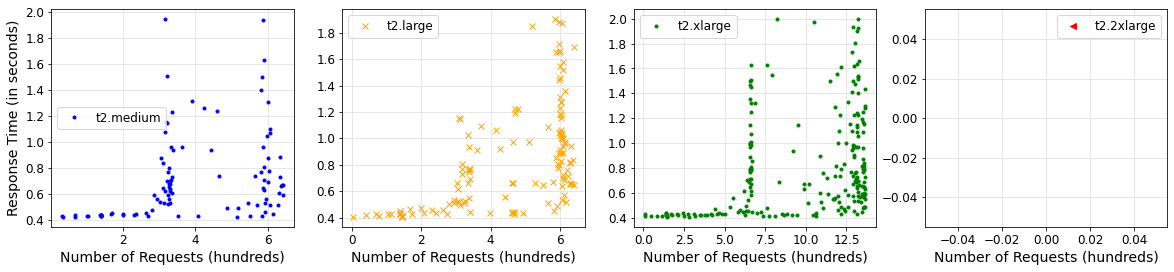

In [56]:
rcParams['figure.figsize'] = 20, 4
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#ax1 = plt.subplot(111)


ax1.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax1.set_xlabel("Number of Requests (hundreds)")
ax1.set_ylabel("Response Time (in seconds)")

ax2.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax2.set_xlabel("Number of Requests (hundreds)")
#ax2.set_ylabel("Response Time (in seconds)")

ax3.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax3.set_xlabel("Number of Requests (hundreds)")
#ax3.set_ylabel("Response Time (in seconds)")

ax4.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax4.set_xlabel("Number of Requests (hundreds)")
#ax4.set_ylabel("Response Time (in seconds)")


ax1.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['responsetime'],'.', label = "t2.medium", color="blue")
ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['responsetime'], 'x', label = "t2.large", color="orange")
ax3.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['responsetime'], '.',label = "t2.xlarge", color="green")
ax4.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['responsetime'], '<', label = "t2.2xlarge", color="red")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.show()

In [57]:
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
x_train = skpreprocessing.normalize(x_train, norm='l2')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
x_test = skpreprocessing.normalize(x_test, norm='l2')
#plt.scatter(df_ttest['requests'], df_ttest['total_cpu_util'] )
#plt.show()
#plt.scatter(df_t['requests'], df_t['total_cpu_util'] )
#plt.show()

# Linear Regression

In [58]:
%%time
#parameters = {'fit_intercept': [True,False],
#             'copy_X': [True,False]}
#linear = GridSearchCV(LinearRegression(),
#                      parameters, 
#                      cv=7,
#                      scoring='r2',
#                      n_jobs=-1)
linear = LinearRegression(fit_intercept=False)
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)

CPU times: user 4.7 ms, sys: 65 µs, total: 4.77 ms
Wall time: 4.28 ms


In [59]:
%%time
lin_reg_y_te_pred = linear.predict(x_test)

CPU times: user 466 µs, sys: 119 µs, total: 585 µs
Wall time: 586 µs


Training Score  0.869067829491147
Testing Score  0.8740725647647568
R² : 0.8740725647647568


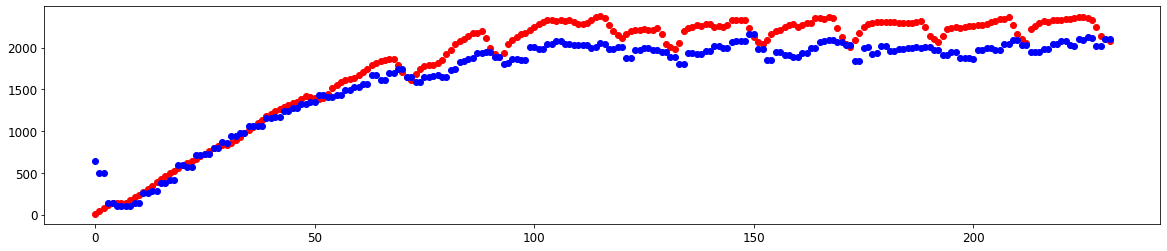

In [60]:
#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",linear.score(x_train,y_train))
linear_score = linear.score(x_test,y_test)
print("Testing Score ",linear_score)

from sklearn.metrics import r2_score
R = r2_score(y_test, lin_reg_y_te_pred)
print ('R² :',R)
#print('Best Score: ', linear.best_score_)
#print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(lin_reg_y_te_pred)),lin_reg_y_te_pred, color='blue')
plt.show()
#plt.plot(y_test)
#plt.plot(lin_reg_y_te_pred)
#plt.show()

# Polynomial Regression

In [61]:
%%time
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [2]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      scoring='r2')
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)

CPU times: user 20.9 ms, sys: 0 ns, total: 20.9 ms
Wall time: 24.9 ms


In [62]:
%%time
poly_reg_y_te_pred = polynomial.predict(x_test)


CPU times: user 3.36 ms, sys: 0 ns, total: 3.36 ms
Wall time: 2.7 ms


Training Score  0.9025653302990301
Testing Score  -146.86030368690325
R² : -146.86030368690325
Best Params:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}


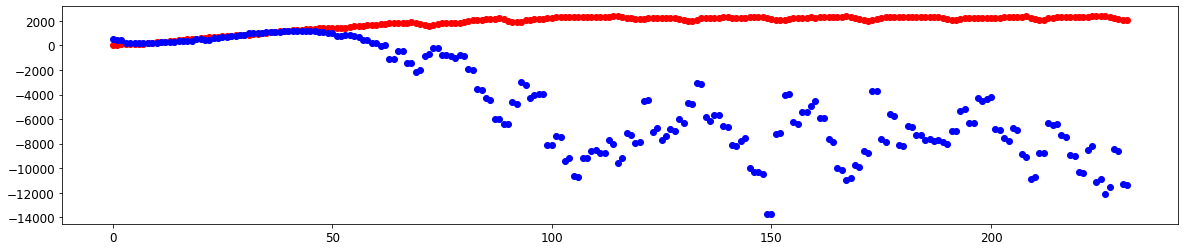

In [63]:
#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",polynomial.score(x_train,y_train))
polynomial_score = polynomial.score(x_test,y_test)
print("Testing Score ",polynomial_score)

from sklearn.metrics import r2_score
R = r2_score(y_test, poly_reg_y_te_pred)
print ('R² :',R)
#print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(poly_reg_y_te_pred)),poly_reg_y_te_pred, color='blue')

# Ridge Regression

In [64]:
%%time
alphas = [2.976351441631313e-11]
param_grid = {'max_iter': [10],
             'alpha': alphas,
            'solver': ['auto'],
             'fit_intercept':[True]}
ridge_cv = GridSearchCV(Ridge(),
                       param_grid=param_grid,
                         scoring='r2')

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 37.3 ms


In [65]:
%%time
ridge_cv_y_te_pred = ridge_cv.predict(x_test)

CPU times: user 317 µs, sys: 0 ns, total: 317 µs
Wall time: 324 µs


Training Score  0.8832240589459457
Testing Score  0.8461674921256015
Best Params:  {'alpha': 2.976351441631313e-11, 'fit_intercept': True, 'max_iter': 10, 'solver': 'auto'}


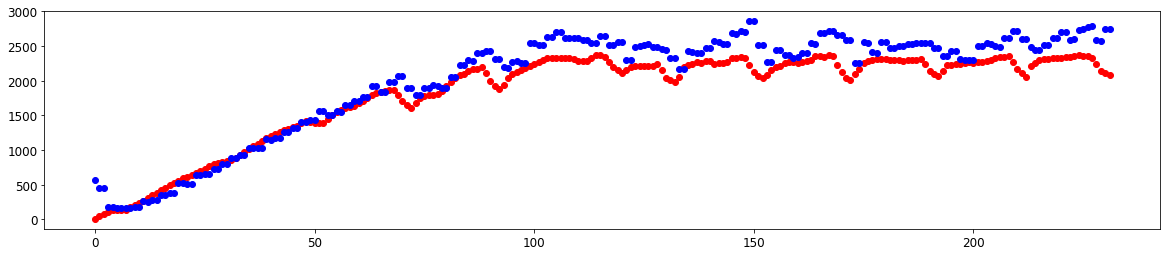

In [66]:
print("Training Score ",ridge_cv.score(x_train,y_train))
ridge_cv_score = ridge_cv.score(x_test,y_test)
print("Testing Score ",ridge_cv_score)

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(ridge_cv_y_te_pred)),ridge_cv_y_te_pred, color='blue')

# Random Forrest

In [67]:
%%time
parameters = {  
                 'min_samples_leaf': [4],
                 'max_depth': [5],
                 'n_estimators': [100],
                'max_features': ['auto']
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      scoring='r2')

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)

CPU times: user 834 ms, sys: 0 ns, total: 834 ms
Wall time: 1.08 s


In [68]:
%%time
rf_cv_y_te_pred = rf_cv.predict(x_test)

CPU times: user 6.95 ms, sys: 0 ns, total: 6.95 ms
Wall time: 9.23 ms


Training Score  0.9414311604648676
Testing Score  -1.029794803821035
Best Params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 100}


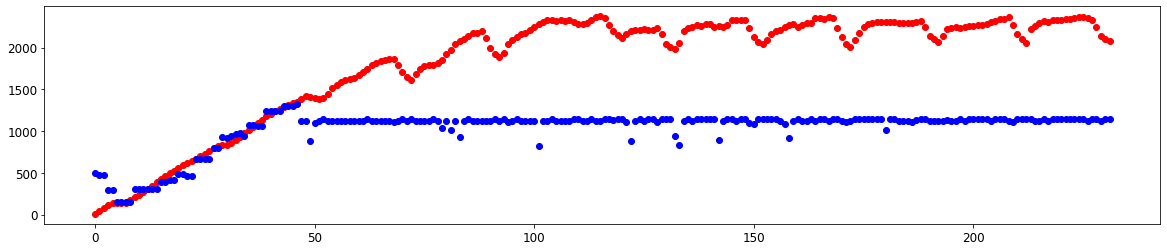

In [69]:
print("Training Score ",rf_cv.score(x_train,y_train))
rf_cv_score = rf_cv.score(x_test,y_test)
print("Testing Score ",rf_cv_score)

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(rf_cv_y_te_pred)),rf_cv_y_te_pred, color='blue')

In [70]:
testPre_df = []
def plot_loss(history):
  history.history['loss'] = np.array(history.history['loss'])/max(max(np.array(history.history['loss'])), max(np.array(history.history['val_loss'])))
  history.history['val_loss'] = np.array(history.history['val_loss'])/max(max(np.array(history.history['loss'])), max(np.array(history.history['val_loss'])))
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  return plt.savefig("LossSenti.png",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

def plot_prediction(test_labels, test_predictions, i, alpha,label):
    color = ['green','red','orange', 'brown', 'pink', 'brown','blue']
    shape = ['1','2','3','4','+',',','x']
    rcParams['figure.figsize'] = 5, 5
    rcParams['axes.labelsize'] = 12
    rcParams['axes.titlesize'] = 20
    rcParams["font.size"] = 12
    a = plt.axes(aspect='equal')
    #test_predictions = test_predictions/max(test_predictions)
    #test_labels = test_labels/max(test_labels)
    m1, b1 = 1.0, 1.0
    m2, b2 = 1.0, -250.0
    m3, b3 = 1.0, 250.0
    m4, b4 = 1.0, -500.0
    m5, b5 = 1.0, 500.0
    x = np.linspace(0,70000,500)
    plt.plot(x,x*m1+b1, color='black', alpha=1, linewidth=1)
    plt.plot(x,x*m2+b2, ':',color='red', alpha=0.5, linewidth=1)
    plt.plot(x,x*m3+b3, ':',color='red', alpha=0.5, linewidth=1)
    plt.plot(x,x*m4+b4, '-',color='grey', alpha=0.1, linewidth=1)
    plt.plot(x,x*m5+b5, '-',color='grey', alpha=0.1, linewidth=1)
    plt.plot(test_labels, test_predictions,shape[i], color=color[i], label=label,alpha=alpha)
    plt.xlabel('True Values (Number of Requests)')
    plt.ylabel('Predictions (Number of Requests)')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.legend()
    #_ = plt.plot(lims, lims)
    plt.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
    return plt.savefig("PredictionSenti.png",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [71]:
%%time
i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
test_predictions = []
loss, score, model = [], [], []
#hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values

kf = KFold(n_splits=6, random_state=42, shuffle=True)
#print(kf)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    
    dnn_model = build_and_compile_model(input_normalizer)

    #print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    loss_cal=dnn_model.evaluate(val_features, val_labels,verbose=0)
    #plot_loss(history)
    loss.append(loss_cal)
    ## Make Predictions
    test_predictions.append(dnn_model.predict(test_features).flatten())
    
    #testPre_df.append(test_predictions)
    R = r2_score(test_labels, test_predictions[i])*100
    if(nn_score<R) or (i==0):
        nn_score = R
        loss_exp = loss_cal
        nn_prediction = test_predictions[i]
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #model['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

#data = np.array([model, loss, score]).T
#pd.DataFrame(data,columns=["model", "loss", "score"])

CPU times: user 25 s, sys: 2.6 s, total: 27.6 s
Wall time: 20.4 s


[83.009 79.443 85.594 80.515 83.347 80.106]


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier inst

CPU times: user 2.49 s, sys: 97.1 ms, total: 2.59 s
Wall time: 2.58 s


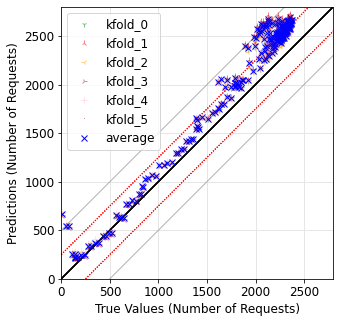

In [72]:
%%time
print(score)
test_prediction = sum(test_predictions)/len(test_predictions)
test_predictions.append(test_prediction)
#test_predictions = dnn_model.predict(test_features).flatten()
for i in range(0,7):
    if i==6:
        plot_prediction(test_labels, test_predictions[i],i,1, label='average')
    else:
        plot_prediction(test_labels, test_predictions[i],i,0.5, label='kfold_'+str(i))

i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
rcParams['figure.figsize'] = 18, 8
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
ax = []
fig = plt.subplots()
fig, axs = plt.subplots(2, 3)
#fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3)
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values

kf = KFold(n_splits=6, shuffle=False)
print(kf.split(X))
plot = []
labels = []
cap = 0
#val_labels = []
for train_index, test_index in kf.split(X):
    #print("TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    t_labels, v_labels = np.hstack(y[train_index]), np.hstack(y[test_index])
    plot.append(np.concatenate((train_index, test_index), axis=0))
    labels.append(np.concatenate((t_labels, v_labels)))
    #val_labels.append(v_labels)
    #train, test = train_index, test_index
    #ax.scatter(val_features,val_labels)
    #print(v_labels)
    #print(labels)
    cap = len(train_index)
    #plt.plot(v_labels)
    #plt.plot(t_labels)
    #plt.show()
    
for col,ax in zip(range(0,6), axs.flatten()):
    colu = []
    for i in range(0, len(plot[col])): 
        if (i<cap): 
            colu.append('blue')   
        else: 
            colu.append('orange')
    data = np.array([labels[col],colu]).T
    df_data = pd.DataFrame(data,columns=["labels", "color"])
    #print(val_labels)
    #print(colu)
    #df_data = df_data.sort_values(by="plot")
    #print(df_data['plot'])
    ax.scatter(range(0,len(df_data['labels'])),df_data['labels'],c = df_data['color'], label = "val_labels")
    #ax.scatter(range(0,len(plot[col])),plot[col],c = colu, label = "val_labels")
    #ax.scatter(range(0,len(train_labels[col])),train_labels[col], label = "train_labels", color="red")
    #ax.plot(range(0,len(train_labels[col])),train_labels[col])
        
            #ax.set_title(self.df.columns[col])
#ax.plot(range(0,len(val_labels)), val_labels)

In [ ]:
%%time
i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values

kf = KFold(n_splits=6, random_state=42, shuffle=True)
#print(kf)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    
    dnn_model = build_and_compile_model(input_normalizer)

    #print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    loss_cal=dnn_model.evaluate(val_features, val_labels,verbose=0)
    #plot_loss(history)
    #loss.append(loss_cal)
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()
    
    #testPre_df.append(test_predictions)
    #plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    if(nn_score<R) or (i==0):
        nn_score = R
        loss_exp = loss_cal
        nn_prediction = test_predictions
    #model.append('dnn_model_'+str(i))
    #score.append(R)
    #i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
#model = np.array(model)
#score = np.array(score)
#loss = np.array(loss)

#data = np.array([model, loss, score]).T
#pd.DataFrame(data,columns=["model", "loss", "score"])

In [ ]:
%%time
test_predictions = dnn_model.predict(test_features).flatten()

In [ ]:
plot_prediction(test_labels, nn_prediction)

In [ ]:
R = r2_score(test_labels, nn_prediction)*100

In [ ]:
print(R)

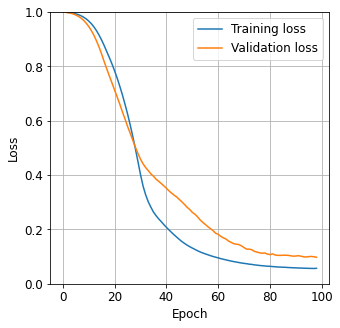

In [25]:
plot_loss(history)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss']+history.history['val_loss'])+100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

def plot_prediction(test_labels, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values requests')
    plt.ylabel('Predictions requests')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    return plt.show()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#%%time
i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values
kf = KFold(n_splits=6, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    plot_loss(history)
    loss_cal=dnn_model.evaluate(val_features, val_labels,verbose=0)
    loss.append(loss_cal)
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()

    plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    if(nn_score<R) or (i==0):
        nn_score = R
        loss_exp = loss_cal
        nn_prediction = test_predictions
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams["legend.loc"] = 'upper left'
rcParams['axes.labelsize'] = 10
rcParams['axes.titlesize'] = 5
rcParams["font.size"] = 10
plt.plot(range(0,len(test_labels)),test_labels, color='green',label='True Value')
plt.plot(range(0,len(lin_reg_y_te_pred)),lin_reg_y_te_pred, color='red', label='Linear Regression')
plt.plot(range(0,len(poly_reg_y_te_pred)),poly_reg_y_te_pred, color='blue', label='Polynomial Linear Reg')
plt.plot(range(0,len(ridge_cv_y_te_pred)),ridge_cv_y_te_pred, color='brown', label='Ridge Reg')
plt.plot(range(0,len(rf_cv_y_te_pred)),rf_cv_y_te_pred, color='grey', label='Random Forrest')
plt.plot(range(0,len(nn_prediction)),nn_prediction, color='violet', label='Deep Neural Network')
plt.legend(loc="lower right")
plt.ylabel('Number of Requests')
plt.show()

In [ ]:
models = np.array(['Linear Regression', 'Polynomial Linear Reg', 'Ridge Reg', 'Random Forrest', 'Deep Neural Network'])
model_score = np.array([linear_score*100, polynomial_score*100, ridge_cv_score*100, rf_cv_score*100, nn_score])
data = np.array([models, model_score]).T
pd.DataFrame(data,columns=["models", "model_score"])